## Lane Shape Modeling
1) load the trained Instance Segmentation model
2) predict lane masks
3) fit mathematical equations (Polynomials/Splines) to the detected lanes.

In [ ]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Configuration
BASE_DIR = os.getcwd()
DATA_DIR = r'C:\ADAS_Project\TUSimple_Small'
TRAIN_SET_DIR = os.path.join(DATA_DIR, 'train_set')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, r'processed\instance')
CHECKPOINT_DIR = os.path.join(BASE_DIR, r'checkpoints\instance')

# polynomial degree to fit
polynomial_degree = 2 

# vertical: 30 meters / 288 pixels
YM_PER_PIX = 30 / 288 
# horizontal: 3.7 meters / 200 pixels (approx lane width in this view)
XM_PER_PIX = 3.7 / 200 

NUM_CLASSES = 6 
IMG_HEIGHT = 288
IMG_WIDTH = 512
EPOCHS = 5 
BATCH_SIZE = 8
LEARNING_RATE = 5*1e-4
model_filename = f'best_model_instance_e{EPOCHS}.pth'
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, model_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Model & Dataset Definitions
Same as lane detection

In [ ]:
class TuSimpleDataset(Dataset):
    def __init__(self, root_dir, processed_dir, json_files, transform=None):
        self.root_dir = root_dir
        self.processed_dir = processed_dir
        self.transform = transform
        self.samples = []

        for json_file in json_files:
            json_path = os.path.join(root_dir, json_file)
            if not os.path.exists(json_path):
                continue
                
            with open(json_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                info = json.loads(line)
                raw_file = info['raw_file']
                mask_file = raw_file.replace('.jpg', '.png')
                img_path = os.path.join(self.root_dir, raw_file)
                mask_path = os.path.join(self.processed_dir, mask_file)
                self.samples.append((raw_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_rel_path, mask_rel_path = self.samples[idx]
        img_path = os.path.join(self.root_dir, img_rel_path)
        mask_path = os.path.join(self.processed_dir, mask_rel_path)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        return image, mask

In [23]:
# U-Net Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        return out

## 2. Curve Fitting Functions

In [24]:
def fit_poly(x, y, degree):
    try:
        poly_coeffs = np.polyfit(y, x, degree)
        poly_func = np.poly1d(poly_coeffs)
        return poly_func, poly_coeffs
    except np.linalg.LinAlgError:
        return None, None

def fit_spline(x, y, s=0.0):
    """Fits a B-spline representation to the lane points."""
    try:
        # Remove duplicates, sort by Y to ensure monotonicity if possible, but splprep handles general parametric
        # splrep is for y=f(x), splprep is for parametric (x(t), y(t))
        # For lanes, usually monotonic in Y. 
        
        # Let's clean data first: unique points
        points = np.column_stack((x, y))
        _, unique_indices = np.unique(points, axis=0, return_index=True)
        points = points[np.sort(unique_indices)]
        
        if len(points) < 4:
            return None, None
            
        tck, u = splprep(points.T, u=None, s=s, per=0, k=min(3, len(points)-1))
        return tck, u
    except Exception as e:
        # print(f"Spline fit failed: {e}")
        return None, None

def measure_curvature(y_vals, poly_coeffs):
    """
    Calculates the curvature of the polynomial at the bottom of the image.
    Returns radius of curvature in meters.
    """
    # Define y-value where we want radius of curvature (bottom of the image)
    y_eval = np.max(y_vals)
    
    # Recalculate polynomials in world space
    # x = ay^2 + by + c
    # We need to scale the coefficients to meters
    # A_m = A_pix * (xm / ym^2)
    # B_m = B_pix * (xm / ym)
    A = poly_coeffs[0]
    B = poly_coeffs[1]
    
    A_m = A * (XM_PER_PIX / (YM_PER_PIX ** 2))
    B_m = B * (XM_PER_PIX / YM_PER_PIX)
    
    # R = ((1 + (2Ay + B)^2)^1.5) / |2A|
    R_curve = ((1 + (2*A_m*y_eval*YM_PER_PIX + B_m)**2)**1.5) / np.absolute(2*A_m)
    return R_curve

def measure_offset(poly_coeffs, img_height, img_width):
    """
    Calculates vehicle offset from the center of the lane.
    Assumes camera is centered in the car.
    """
    # Calculate x position at the bottom of the image
    y_eval = img_height
    x_lane_pix = poly_coeffs[0]*y_eval**2 + poly_coeffs[1]*y_eval + poly_coeffs[2]
    
    # Image center
    x_center_pix = img_width / 2
    
    # Offset in pixels
    offset_pix = x_lane_pix - x_center_pix
    
    # Convert to meters
    offset_m = offset_pix * XM_PER_PIX
    return offset_m

## 3. Execution & Visualization

In [ ]:
def evaluate_shapes(model_path, data_dir, processed_dir, json_files, polydegree):
    num_visualize = 3
    dataset = TuSimpleDataset(data_dir, processed_dir, json_files)
    loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()
    
    # Colors for visualization (up to 5 lanes)
    colors = [
        (0, 0, 0),       # Background
        (0, 255, 0),     # Lane 1
        (255, 0, 0),     # Lane 2
        (0, 0, 255),     # Lane 3
        (255, 255, 0),   # Lane 4
        (255, 0, 255)    # Lane 5
    ]
    
    count = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Fitting Shapes"):
            if count >= num_visualize: break
            
            images = images.to(device)
            #masks = masks.to(device)
            
            output = model(images)
            probs = torch.softmax(output, dim=1)
            pred_mask = torch.argmax(probs, dim=1).cpu().numpy()[0]
            
            # Original Image Prep
            img_np = images[0].cpu().permute(1, 2, 0).numpy()
            img_np = (img_np * 255).astype(np.uint8)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
            
            viz_img = img_np.copy()
            
            # Fitting logic
            height, width = pred_mask.shape
            plot_y = np.linspace(0, height-1, height)
            
            # We iterate classes 1..NUM_CLASSES
            for cls_idx in range(1, NUM_CLASSES):
                lane_mask = (pred_mask == cls_idx).astype(np.uint8)
                
                if np.sum(lane_mask) > 100: # Threshold for validity
                    # Extract points
                    y_coords, x_coords = np.where(lane_mask == 1)
                    
                    # Fit Polynomial
                    try:
                        lane_fit = np.polyfit(y_coords, x_coords, polydegree)
                        lane_fitx = np.polyval(lane_fit, plot_y)
                        
                        # Draw Points
                        pts = np.array([np.transpose(np.vstack([lane_fitx, plot_y]))])
                        pts = pts.astype(np.int32)
                        
                        color_rgb = colors[cls_idx if cls_idx < len(colors) else 1]
                        # cv2 uses BGR
                        color_bgr = (color_rgb[2], color_rgb[1], color_rgb[0])
                        
                        cv2.polylines(viz_img, pts, isClosed=False, color=color_bgr, thickness=5)
                    except Exception as e:
                        pass # Polyfit might fail on weird points
            
            # Plot
            plt.figure(figsize=(10, 5))
            plt.title("Lane Shape Modeling (Polynomial Fit)")
            plt.imshow(cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
            
            count += 1


Loaded model from C:\ADAS_Project\ADAS-Project\checkpoints\instance\best_model_instance_e20.pth


Fitting Shapes:   0%|          | 0/906 [00:00<?, ?it/s]

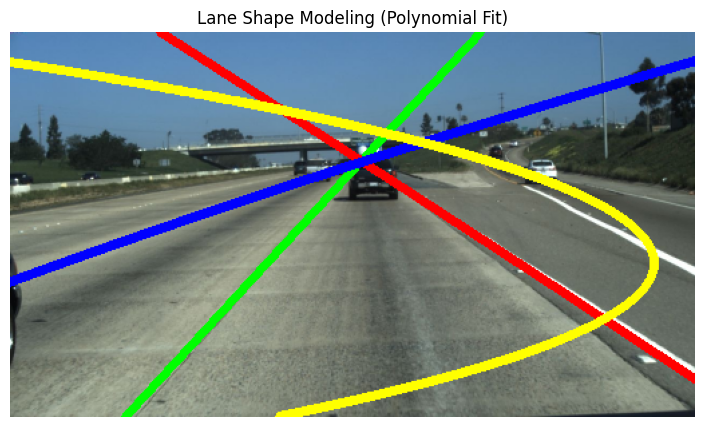

Fitting Shapes:   0%|          | 1/906 [00:00<05:14,  2.88it/s]

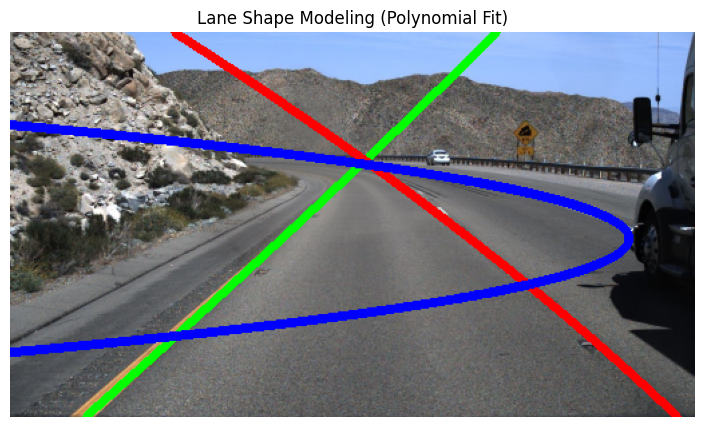

Fitting Shapes:   0%|          | 2/906 [00:00<05:33,  2.71it/s]

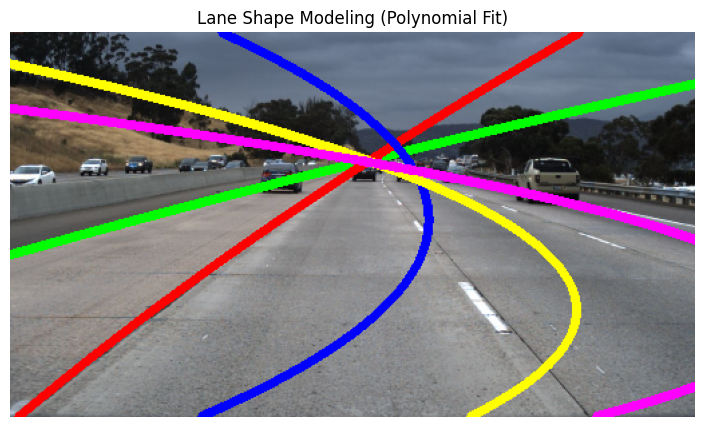

Fitting Shapes:   0%|          | 3/906 [00:01<05:32,  2.72it/s]


In [26]:

# Run
json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
evaluate_shapes(r'C:\ADAS_Project\ADAS-Project\checkpoints\instance\best_model_instance_e20.pth', TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files,polynomial_degree)